# real-time gait event detection from markers
## based off of Zeni et al. paper and Karakasis et al. paper
**Aim:** write and evaluate a script that can be used in real-time to detect a heel strike and toe-off using only marker data
### pseudocode
1. ~import one subject's walking data~
2. ~get ground truth for heel strikes and toe-off~
3. heel strike: (F-VESPA from Karakasis)
* ~calculate vertical velocity of heel marker ( first-order finite difference approximation)~
* ~find local max of 2 past and 2 future samples~
* ~compute sagittal velocity of heel marker~
* ~find local minimum of heel vertical velocity with 3 past and 1 future~
* ~check if sagittal velocity is negative; if yes, it's a HS~
4. toe-off (pelvis thing)
* ~extension of local min for pelvis and toe marker~


### notes:
- you will have to check if the delay in feedback cue based on the delay in estimating heel strike is different across subjects, because this could introduce an unwanted variable in your feedback (people are getting it too late)
- to generalize checking with other subs and other trials, either a) clean up the GRF data or b) label which are HS and TO
- really you might not even need TO because you could just get HS, wait until there's a stable FPA, then already begin computing before you hit TO
- maybe try the realtime version of zeni for HS as well to see if it works better

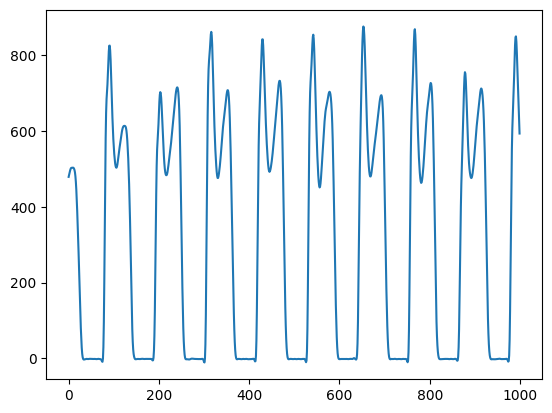

In [19]:
# 0. import walking data from csv

# a. import pandas and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
# b. import data
lcal = pd.read_csv('s05\s05_b_Rcal.csv').loc[1000:6000]
ltoe = pd.read_csv('s05\s05_b_Rtoe.csv').loc[1000:6000]
lgrf = pd.read_csv('s05\s05_b_RGRF.csv').loc[1000:6000]
lpsi = pd.read_csv('s05\s05_b_Rpsi.csv').loc[1000:6000]

#c. visualize vGRF 
plt.plot(lgrf.values[0:1000,1]) # [ML, V, AP]

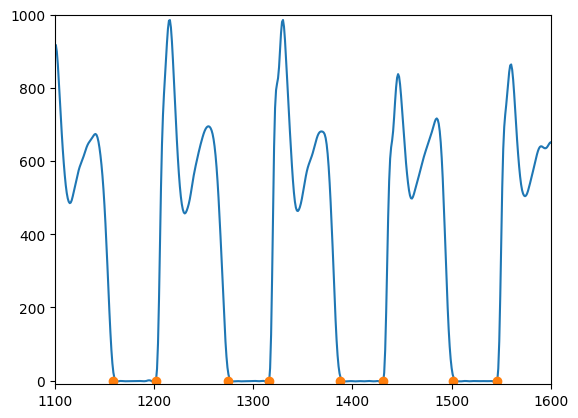

[]


In [20]:
# 1. get ground truth for heel strikes and toe-off (from old methods)
# a. find HS and TO events
def getZeroCross(vGRF):
    zero_crossings = np.where(np.diff(np.sign(vGRF-10)))[0] # find index where signal crosses 10N
    return zero_crossings

# b. execute function
zero_crossings = getZeroCross(lgrf.values[:,1])

# c. visualize
plt.plot(lgrf.values[:,1]) # [ML, V, AP]
plt.plot(zero_crossings, np.zeros(len(zero_crossings)), 'o')

ax = plt.gca()
ax.set_xlim([1100, 1600])
ax.set_ylim([-10, 1000])

plt.show()


# identify which is HS and which is TO
hs_true = np.empty(0)
to_true = np.empty(0)
print(to_true)
# loop through list of ZC indices
for i in range(1, len(zero_crossings)):
    # if val(ind+10) > val(ind)+15 then it's HS; add to HS_ind_list
    if lgrf.values[zero_crossings[i]+10,1]>lgrf.values[zero_crossings[i],1]+15: 
        hs_true = np.append(hs_true, zero_crossings[i])
        # if val(ind+10) <= val(ind) + 15 then it's TO and signal~0
    elif lgrf.values[zero_crossings[i]+10,1]<=lgrf.values[zero_crossings[i],1]+15:
        to_true = np.append(to_true, zero_crossings[i])
    else:
        print("error??")


In [21]:
# 2. HEEL STRIKE

lcal_Vvel = np.zeros(len(lcal.values))
lcal_Hvel = np.zeros(len(lcal.values))
hs_inds = np.empty(0)
y_GM = 0.1 #might need to tune this; global maximum
flag = 0
for i in range(1, len(lcal.values)): #start with second data point
    lcal_Vvel[i] = lcal.values[i,1] - lcal.values[i-1,1] #calc velocity sign
    lcal_Hvel[i] = lcal.values[i,0] - lcal.values[i-1,0] #horizontal vel
    
    # get to 5th data point
    if i>4:
        if lcal_Vvel[i]<0 and lcal_Vvel[i-1]<0 and lcal_Vvel[i-2]>=0 and lcal_Vvel[i-3]>=0 and lcal.values[i-2,1]>y_GM:
            # then k-2 is global max; now look for min
            flag = 1
            
        if flag:
            if lcal_Vvel[i]>=0 and lcal_Vvel[i-1]<=0 and lcal_Vvel[i-2]<=0 and lcal_Vvel[i-3]<=0:            
            # then k-1 is local min (Hs)
                hs_inds = np.append(hs_inds,i-1)
                flag = 0
                

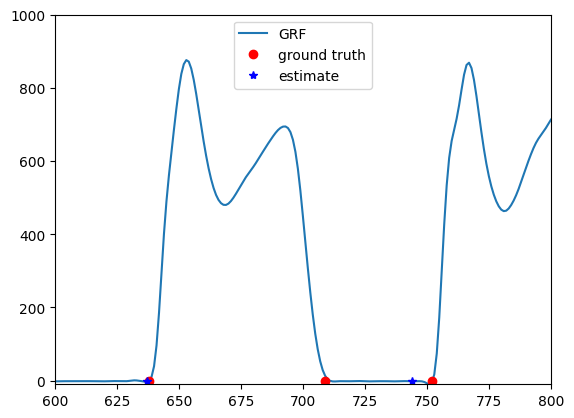

In [22]:
# b. execute function
zero_crossings = getZeroCross(lgrf.values[:,1])

# c. visualize
plt.plot(lgrf.values[:,1], label = "GRF") # [ML, V, AP]
plt.plot(zero_crossings, np.zeros(len(zero_crossings)), 'ro', label = "ground truth")
plt.plot(hs_inds, np.zeros(len(hs_inds)),'b*', label = "estimate")

ax = plt.gca()
ax.set_xlim([600, 800])
ax.set_ylim([-10, 1000])

plt.legend()
plt.show()

MAE =  4.023255813953488  frames
Max error =  10.0  frames


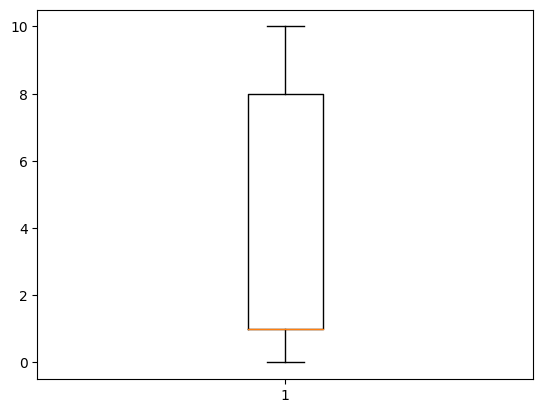

In [23]:
abs_error_hs = (hs_true-hs_inds)

print('MAE = ', np.mean(abs(abs_error_hs[:-1])), ' frames')
print('Max error = ', np.max(abs_error_hs[:-1]),' frames')

plt.boxplot(abs_error_hs[:-1])
plt.show()

# the big errors are infrequent, but usually marker estimates are earlier than ground-truth, which is fine

In [24]:
abs_error_hs

array([ 1.,  8.,  9.,  1.,  0.,  1.,  8., 10.,  8.,  1.,  2.,  1.,  8.,
        1.,  8.,  1.,  7.,  8., 10.,  9., 10.,  8.,  1.,  0.,  1., 10.,
        1.,  8.,  8.,  0.,  1.,  7.,  1.,  0.,  0.,  1.,  1.,  9.,  1.,
        1.,  1.,  1.,  0.,  8.])

(-10.0, 1000.0)

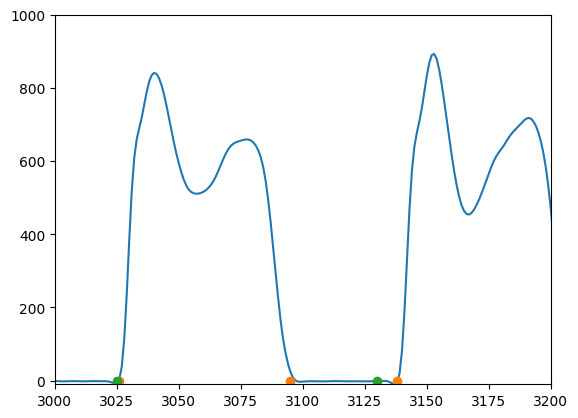

In [25]:
plt.plot(lgrf.values[:,1]) # [ML, V, AP]
plt.plot(zero_crossings, np.zeros(len(zero_crossings)), 'o')
plt.plot(hs_inds, np.zeros(len(hs_inds)),'o')

ax = plt.gca()
ax.set_xlim([3000, 3200])
ax.set_ylim([-10, 1000])

(3000.0, 3200.0)

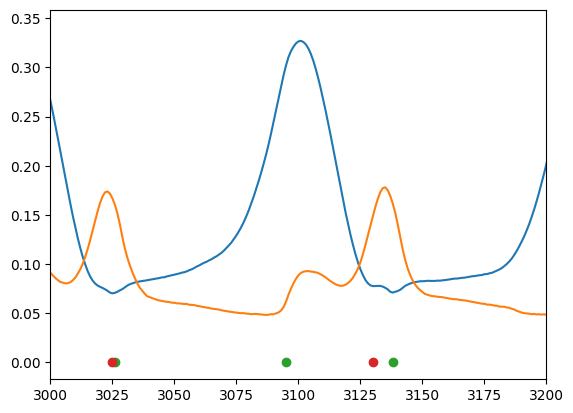

In [26]:
plt.plot(lcal.values[:,1])
plt.plot(ltoe.values[:,1])
plt.plot(zero_crossings, np.zeros(len(zero_crossings)), 'o')
plt.plot(hs_inds, np.zeros(len(hs_inds)),'o')

ax = plt.gca()
ax.set_xlim([3000, 3200])


## toe-off 

(0.0, 320.0)

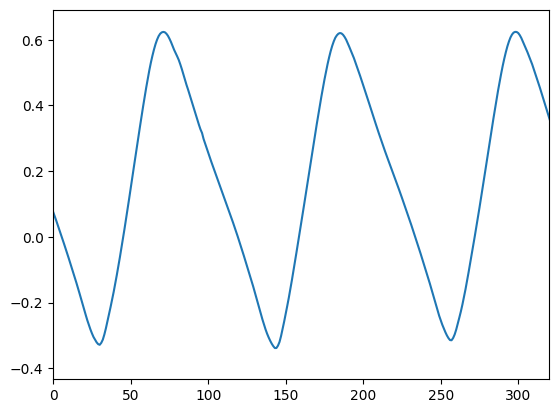

In [27]:
# local min of toe minus sacrum in AP
plt.plot(ltoe.values[:,2]-lpsi.values[:,2])
plt.plot()
ax = plt.gca()
ax.set_xlim([0, 320])

(0.0, 320.0)

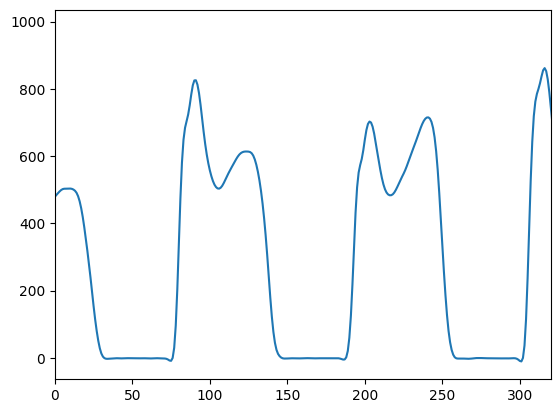

In [28]:
plt.plot(lgrf.values[:,1])
ax=plt.gca()
ax.set_xlim([0,320])

In [29]:
# toe-off local min

toePsiDiff = np.zeros(len(lcal.values))
toePsiDiffVel = np.zeros(len(lcal.values))
to_inds = np.empty(0)
for i in range(1, len(lcal.values)): #start with second data point
    toePsiDiff[i] = ltoe.values[i,2] - lpsi.values[i,2]
    toePsiDiffVel[i] = toePsiDiff[i]-toePsiDiff[i-1]
    
    if i>3:
        if toePsiDiffVel[i]>=0 and toePsiDiffVel[i-1]<=0 and toePsiDiffVel[i-2]<=0 and toePsiDiffVel[i-3]<=0: 
            to_inds = np.append(to_inds, i-1)

In [30]:
to_inds

array([  30.,  143.,  257.,  370.,  484.,  596.,  709.,  818.,  932.,
       1046., 1160., 1275., 1387., 1501., 1617., 1732., 1844., 1957.,
       2070., 2184., 2298., 2415., 2533., 2642., 2757., 2869., 2981.,
       3095., 3209., 3319., 3432., 3545., 3658., 3770., 3881., 3996.,
       4110., 4221., 4335., 4446., 4561., 4673., 4786., 4897.])

In [31]:
to_true

array([ 144.,  256.,  369.,  484.,  596.,  709.,  818.,  932., 1046.,
       1159., 1275., 1387., 1501., 1616., 1731., 1844., 1957., 2070.,
       2185., 2299., 2415., 2532., 2642., 2756., 2868., 2981., 3095.,
       3208., 3318., 3431., 3545., 3657., 3770., 3880., 3996., 4109.,
       4221., 4334., 4446., 4560., 4673., 4786., 4897.])

(-10.0, 1000.0)

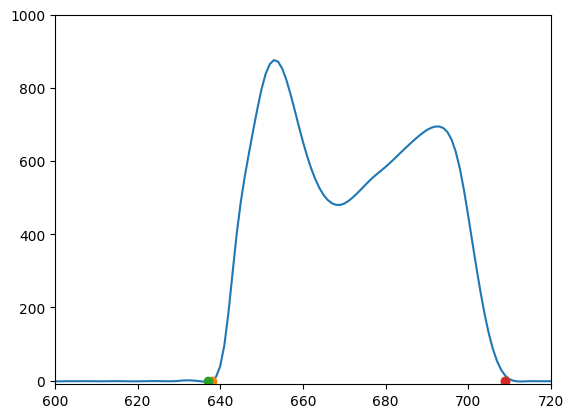

In [32]:
plt.plot(lgrf.values[:,1]) # [ML, V, AP]
plt.plot(zero_crossings, np.zeros(len(zero_crossings)), 'o')
plt.plot(hs_inds, np.zeros(len(hs_inds)),'o')
plt.plot(to_inds, np.zeros(len(to_inds)),'o')

ax = plt.gca()
ax.set_xlim([600, 720])
ax.set_ylim([-10, 1000])

MAE =  0.4523809523809524  frames
Max error =  1.0  frames


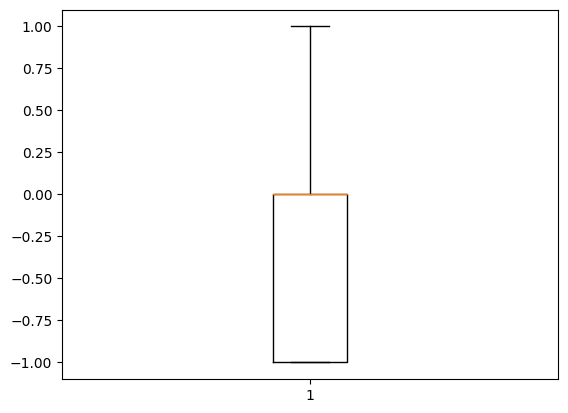

In [33]:


abs_error_to = (to_true-to_inds[1:]) # cut off first estimated index because there is a false local min
print('MAE = ', np.mean(abs(abs_error_to[:-1])), ' frames')
print('Max error = ', np.max(abs_error_to[:-1]),' frames')

plt.boxplot(abs_error_to[:-1])
plt.show()

# usually the marker estimate is 2 frames behind real toe-off, which is fine

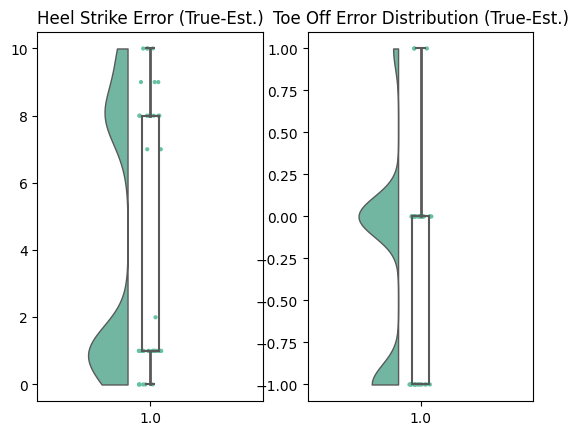

In [34]:
import ptitprince as pt
plt.subplot(1,2,1)
pt.RainCloud(np.ones(len(abs_error_hs)),abs_error_hs)
ax = plt.gca()
ax.set_xlim([-1, 1])
plt.title('Heel Strike Error (True-Est.)')

plt.subplot(1,2,2)
pt.RainCloud(np.ones(len(abs_error_to)),abs_error_to)
ax = plt.gca()
ax.set_xlim([-1, 1])
plt.title('Toe Off Error Distribution (True-Est.)')


plt.show()